# Анализ данных датчика CO2

Этот ноутбук содержит полный цикл обработки данных с датчика CO2 (ESP32-S3 + MH-Z19C + DHT-22):
1. Извлечение данных из DynamoDB
2. Очистка данных
3. Нормализация данных
4. Разметка данных
5. Анализ данных
6. Экспорт результатов

## 1. Извлечение данных из DynamoDB

In [1]:
import boto3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from decimal import Decimal

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style('whitegrid')

In [2]:
# Подключение к DynamoDB
session = boto3.Session(profile_name='personal')
dynamodb = session.resource('dynamodb', region_name='eu-central-1')
table = dynamodb.Table('co2-sensor-data')

device_id = 'esp32-001'
days_back = 30
start_time = int((datetime.now() - timedelta(days=days_back)).timestamp() * 1000)

print(f"Загрузка данных за последние {days_back} дней...")
response = table.query(
    KeyConditionExpression='deviceId = :did AND #ts >= :start',
    ExpressionAttributeNames={'#ts': 'timestamp'},
    ExpressionAttributeValues={':did': device_id, ':start': start_time}
)

data = [{k: float(v) if isinstance(v, Decimal) else v for k, v in item.items()} for item in response['Items']]

with open('sensor_data.json', 'w') as f:
    json.dump(data, f, indent=2)

print(f"Загружено {len(data)} записей")

Загрузка данных за последние 30 дней...
Загружено 315 записей


In [23]:
# Преобразование в DataFrame
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df['datetime'] = df['datetime'].dt.tz_convert('Asia/Ashgabat')  # GMT+5
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Период данных: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"\nПервые записи:")
df.head()

Период данных: 2025-11-02 20:46:13+05:00 - 2025-11-21 00:11:31+05:00

Первые записи:


,ttl,humidity,deviceId,co2,temperature,timestamp,datetime
0,1.793635e+09,39.9,esp32-001,943.0,24.34,1.762098e+12,2025-11-02 20:46:13+05:00
1,1.793635e+09,40.0,esp32-001,914.0,24.34,1.762098e+12,2025-11-02 20:46:28+05:00
2,1.793635e+09,40.2,esp32-001,935.0,24.33,1.762098e+12,2025-11-02 20:46:43+05:00
3,1.793635e+09,39.9,esp32-001,929.0,24.32,1.762098e+12,2025-11-02 20:46:57+05:00
4,1.793635e+09,39.8,esp32-001,921.0,24.31,1.762098e+12,2025-11-02 20:47:12+05:00


In [ ]:
df[:50]

,ttl,humidity,deviceId,co2,temperature,timestamp,datetime
100,1.793637e+09,40.6,esp32-001,1068.0,24.18,1.762101e+12,2025-11-02 21:30:45+05:00
101,1.793637e+09,40.6,esp32-001,1058.0,24.18,1.762101e+12,2025-11-02 21:31:03+05:00
102,1.793637e+09,40.6,esp32-001,1020.0,24.18,1.762101e+12,2025-11-02 21:31:22+05:00
103,1.793637e+09,40.8,esp32-001,989.0,24.18,1.762101e+12,2025-11-02 21:31:41+05:00
104,1.793637e+09,40.7,esp32-001,1013.0,24.18,1.762101e+12,2025-11-02 21:32:00+05:00
...,...,...,...,...,...,...,...
245,1.794158e+09,39.2,esp32-001,797.0,22.19,1.762618e+12,2025-11-08 21:06:24+05:00
246,1.794158e+09,39.3,esp32-001,1061.0,22.35,1.762618e+12,2025-11-08 21:06:56+05:00
247,1.794158e+09,38.9,esp32-001,1022.0,22.39,1.762618e+12,2025-11-08 21:07:10+05:00
248,1.794158e+09,39.0,esp32-001,992.0,22.40,1.762618e+12,2025-11-08 21:07:24+05:00


## 2. Очистка данных

### 2.1. Анализ временных меток

Устройство работает в трех режимах:
- **Онлайн**: синхронизация с NTP, точные временные метки
- **Оффлайн (после синхронизации)**: продолжение с последнего известного времени + 10 сек
- **Оффлайн (без синхронизации)**: относительное время от включения устройства

Необходимо выявить разрывы и аномалии во временных метках.

Статистика интервалов между измерениями (сек):
count       314.000000
mean       4992.095541
std       50010.581339
min           8.776000
25%          16.889000
50%          19.000000
75%          22.000000
max      553091.000000
Name: time_diff, dtype: float64


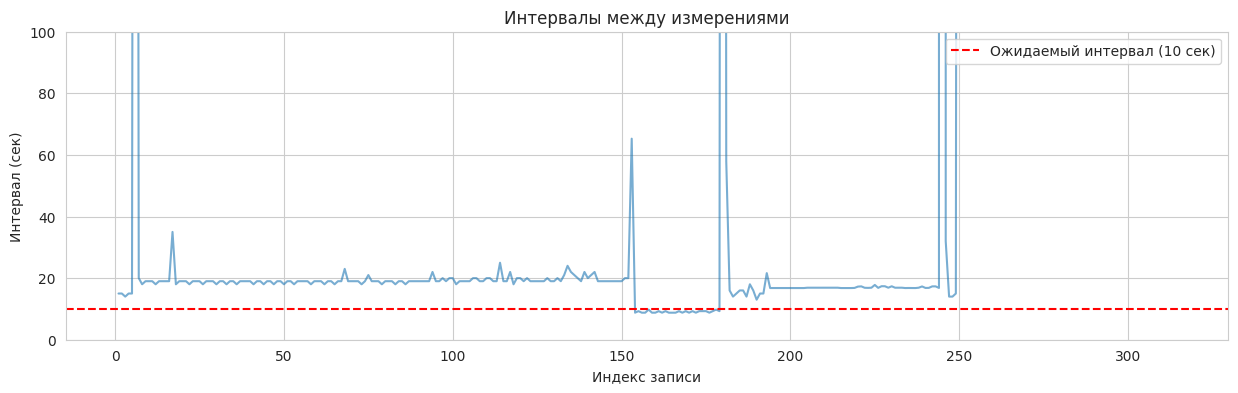


Найдено 69 разрывов более 1 минуты:


In [4]:
# Анализ интервалов между измерениями
df['time_diff'] = df['timestamp'].diff() / 1000  # в секундах

print("Статистика интервалов между измерениями (сек):")
print(df['time_diff'].describe())

# Визуализация интервалов
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['time_diff'], alpha=0.6)
plt.axhline(y=10, color='r', linestyle='--', label='Ожидаемый интервал (10 сек)')
plt.xlabel('Индекс записи')
plt.ylabel('Интервал (сек)')
plt.title('Интервалы между измерениями')
plt.legend()
plt.ylim(0, 100)
plt.show()

# Поиск больших разрывов (более 1 минуты)
gaps = df[df['time_diff'] > 60].copy()
print(f"\nНайдено {len(gaps)} разрывов более 1 минуты:")
if len(gaps) > 0:
    gaps[['datetime', 'time_diff']].head(10)

### 2.2. Идентификация сессий измерений

Разделим данные на сессии по большим временным разрывам (>5 минут).

In [5]:
# Создание ID сессий
df['session_id'] = (df['time_diff'] > 300).cumsum()  # разрыв > 5 минут

# Статистика по сессиям
session_stats = df.groupby('session_id').agg({
    'datetime': ['min', 'max', 'count'],
    'temperature': 'mean',
    'humidity': 'mean',
    'co2': 'mean'
})

session_stats.columns = ['Начало', 'Конец', 'Записей', 'Ср.Темп', 'Ср.Влажн', 'Ср.CO2']
session_stats['Длительность'] = (session_stats['Конец'] - session_stats['Начало'])

print(f"Найдено {len(session_stats)} сессий измерений:\n")
session_stats

Найдено 16 сессий измерений:



,Начало,Конец,Записей,Ср.Темп,Ср.Влажн,Ср.CO2,Длительность
session_id,,,,,,,
0,2025-11-02 20:46:13+05:00,2025-11-02 20:47:27+05:00,6,24.325000,39.983333,931.500000,0 days 00:01:14
1,2025-11-02 21:00:50+05:00,2025-11-02 21:52:54.028000+05:00,174,24.166092,40.264368,1048.379310,0 days 00:52:04.028000
2,2025-11-02 22:13:08+05:00,2025-11-02 22:31:38.916999936+05:00,65,21.536615,44.712121,1447.830769,0 days 00:18:30.916999936
3,2025-11-08 21:06:24+05:00,2025-11-08 21:07:39+05:00,5,22.358000,39.140000,966.600000,0 days 00:01:15
4,2025-11-08 21:23:54+05:00,2025-11-08 21:27:03+05:00,2,24.465000,44.100000,399.000000,0 days 00:03:09
5,2025-11-08 22:13:26+05:00,2025-11-08 22:23:34+05:00,4,24.032500,39.800000,971.500000,0 days 00:10:08
6,2025-11-14 09:02:21+05:00,2025-11-14 09:02:21+05:00,1,23.070000,NaN,1267.000000,0 days 00:00:00
7,2025-11-14 11:15:37+05:00,2025-11-14 13:02:36+05:00,35,23.809429,45.054286,2012.000000,0 days 01:46:59
8,2025-11-14 13:08:46+05:00,2025-11-14 13:27:41+05:00,7,24.115714,45.100000,1999.285714,0 days 00:18:55


### 2.3. Удаление выбросов

Используем метод 3-сигма для удаления аномальных значений. Выбросы часто возникают при включении/выключении устройства.

In [6]:
def remove_outliers_3sigma(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    outliers = (df[column] < lower) | (df[column] > upper)
    print(f"{column}: удалено {outliers.sum()} выбросов (диапазон: {lower:.2f} - {upper:.2f})")
    return ~outliers

# Применение фильтра
mask = remove_outliers_3sigma(df, 'temperature') & \
       remove_outliers_3sigma(df, 'humidity') & \
       remove_outliers_3sigma(df, 'co2')

df_clean = df[mask].copy()
print(f"\nОсталось {len(df_clean)} из {len(df)} записей ({len(df_clean)/len(df)*100:.1f}%)")

temperature: удалено 3 выбросов (диапазон: 16.17 - 30.91)
humidity: удалено 5 выбросов (диапазон: 31.23 - 52.06)
co2: удалено 3 выбросов (диапазон: -502.71 - 3059.04)

Осталось 304 из 315 записей (96.5%)


### 2.4. Удаление краевых эффектов

Удаляем первые 5 минут каждой сессии (стабилизация датчиков).

In [7]:
# Удаление первых 5 минут каждой сессии
def remove_session_edges(group):
    start_time = group['timestamp'].min()
    return group[group['timestamp'] > start_time + 300000]  # +5 минут в мс

df_clean = df_clean.groupby('session_id', group_keys=False).apply(remove_session_edges)
print(f"После удаления краевых эффектов: {len(df_clean)} записей")

После удаления краевых эффектов: 242 записей


### 2.5. Коррекция времени для 8 ноября

**Особый случай**: 8 ноября измерения начались без интернета в 9:50 утра, но временные метки привязаны к 2 ноября. Необходимо:
1. Найти точку разделения между 2 и 8 ноября по изменению значений
2. Сдвинуть временные метки для 8 ноября, установив базовую точку на 9:50

In [ ]:
# Поиск данных около 2 ноября в исходном датасете
nov2_start = pd.Timestamp('2024-11-02 00:00:00', tz='Asia/Ashgabat')
nov2_end = pd.Timestamp('2024-11-03 00:00:00', tz='Asia/Ashgabat')
nov2_data = df[(df['datetime'] >= nov2_start) & (df['datetime'] < nov2_end)].copy()

print(f"Данные около 2 ноября: {len(nov2_data)} записей")
if len(nov2_data) > 0:
    print(f"Период: {nov2_data['datetime'].min()} - {nov2_data['datetime'].max()}")

    # Визуализация для поиска точки разрыва
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    axes[0].plot(nov2_data.index, nov2_data['temperature'])
    axes[0].set_ylabel('Температура (°C)')
    axes[0].set_title('Поиск точки разделения 2 и 8 ноября')

    axes[1].plot(nov2_data.index, nov2_data['humidity'])
    axes[1].set_ylabel('Влажность (%)')

    axes[2].plot(nov2_data.index, nov2_data['co2'])
    axes[2].set_ylabel('CO2 (ppm)')
    axes[2].set_xlabel('Индекс')

    plt.tight_layout()
    plt.show()
else:
    print("Данные 2 ноября не найдены. Пропускаем коррекцию.")

Данные около 2 ноября: 0 записей
Данные 2 ноября не найдены. Пропускаем коррекцию.


In [ ]:
# Поиск точки разрыва по резкому изменению значений
if len(nov2_data) > 10:
    nov2_data['temp_change'] = nov2_data['temperature'].diff().abs()
    nov2_data['co2_change'] = nov2_data['co2'].diff().abs()
    nov2_data['total_change'] = nov2_data['temp_change'] + nov2_data['co2_change'] / 100

    # Находим максимальное изменение (вероятная точка разрыва)
    split_idx = nov2_data['total_change'].idxmax()
    split_time = nov2_data.loc[split_idx, 'datetime']

    print(f"Точка разделения найдена: индекс {split_idx}, время {split_time}")
    print(f"Изменение температуры: {nov2_data.loc[split_idx, 'temp_change']:.2f}°C")
    print(f"Изменение CO2: {nov2_data.loc[split_idx, 'co2_change']:.0f} ppm")

    # Коррекция времени для данных после разрыва (8 ноября)
    nov8_target = pd.Timestamp('2024-11-08 09:50:00', tz='Asia/Ashgabat')
    time_shift = (nov8_target - split_time).total_seconds() * 1000  # в миллисекундах

    # Применяем сдвиг к обоим датасетам
    for dataset in [df, df_clean]:
        mask_to_shift = dataset.index >= split_idx
        dataset.loc[mask_to_shift, 'timestamp'] = dataset.loc[mask_to_shift, 'timestamp'] + time_shift
        dataset.loc[mask_to_shift, 'datetime'] = pd.to_datetime(dataset.loc[mask_to_shift, 'timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Ashgabat')

    print(f"\nВременной сдвиг применен: {time_shift/1000/3600:.2f} часов")
    print(f"Новое время начала 8 ноября: {df.loc[split_idx, 'datetime']}")
else:
    print("Недостаточно данных для поиска точки разрыва.")

Недостаточно данных для поиска точки разрыва.


### 2.6. Удаление тестовых данных 2 ноября

Удаляем короткий период тестирования устройства 2 ноября.

In [10]:
# Удаление данных 2 ноября (тестовый период)
nov2_start = pd.Timestamp('2024-11-02 00:00:00', tz='Asia/Ashgabat')
nov2_end = pd.Timestamp('2024-11-03 00:00:00', tz='Asia/Ashgabat')

before_removal = len(df_clean)
df_clean = df_clean[~((df_clean['datetime'] >= nov2_start) & (df_clean['datetime'] < nov2_end))].copy()
print(f"Удалено {before_removal - len(df_clean)} записей тестового периода 2 ноября")
print(f"Осталось {len(df_clean)} записей")

Удалено 0 записей тестового периода 2 ноября
Осталось 242 записей


## 3. Нормализация данных

### 3.1. Сглаживание данных

Применяем скользящее среднее для уменьшения шума датчиков.

In [11]:
# Скользящее среднее (окно 6 измерений = 1 минута)
window = 6
df_clean['temperature_smooth'] = df_clean['temperature'].rolling(window=window, center=True).mean()
df_clean['humidity_smooth'] = df_clean['humidity'].rolling(window=window, center=True).mean()
df_clean['co2_smooth'] = df_clean['co2'].rolling(window=window, center=True).mean()

# Заполнение NaN на краях
df_clean['temperature_smooth'].fillna(df_clean['temperature'], inplace=True)
df_clean['humidity_smooth'].fillna(df_clean['humidity'], inplace=True)
df_clean['co2_smooth'].fillna(df_clean['co2'], inplace=True)

print("Сглаживание применено (окно 1 минута)")

Сглаживание применено (окно 1 минута)


### 3.2. Визуализация до и после нормализации

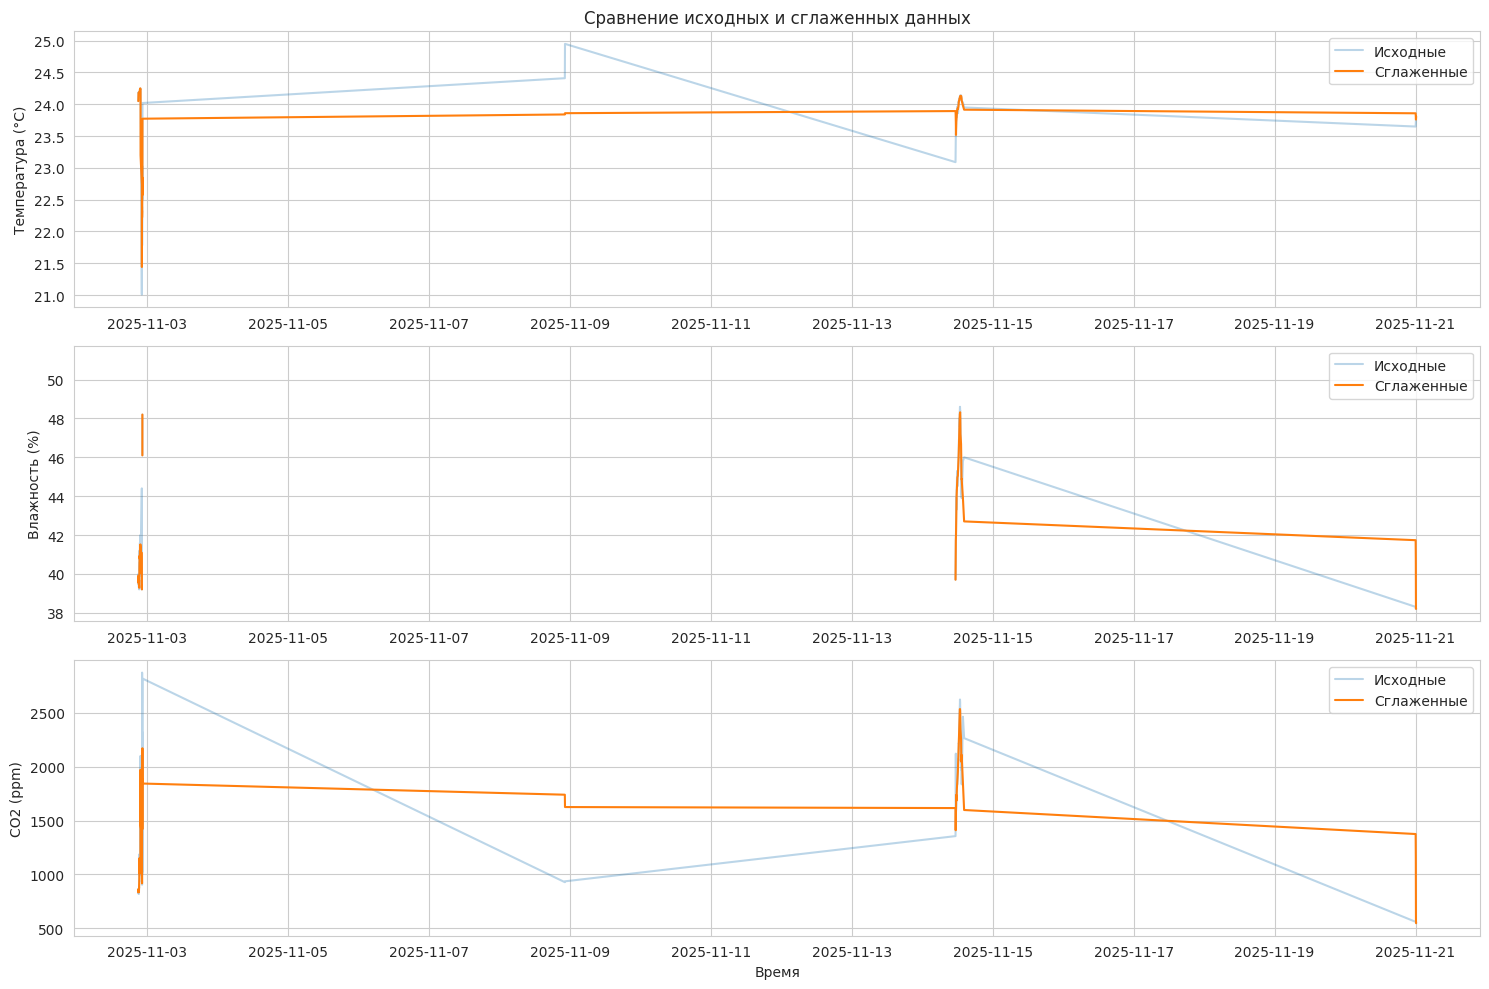

In [12]:
# Сравнение исходных и сглаженных данных
sample = df_clean.iloc[:500]  # первые 500 записей для примера

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].plot(sample['datetime'], sample['temperature'], alpha=0.3, label='Исходные')
axes[0].plot(sample['datetime'], sample['temperature_smooth'], label='Сглаженные')
axes[0].set_ylabel('Температура (°C)')
axes[0].legend()
axes[0].set_title('Сравнение исходных и сглаженных данных')

axes[1].plot(sample['datetime'], sample['humidity'], alpha=0.3, label='Исходные')
axes[1].plot(sample['datetime'], sample['humidity_smooth'], label='Сглаженные')
axes[1].set_ylabel('Влажность (%)')
axes[1].legend()

axes[2].plot(sample['datetime'], sample['co2'], alpha=0.3, label='Исходные')
axes[2].plot(sample['datetime'], sample['co2_smooth'], label='Сглаженные')
axes[2].set_ylabel('CO2 (ppm)')
axes[2].legend()
axes[2].set_xlabel('Время')

plt.tight_layout()
plt.show()

## 4. Разметка данных

### 4.1. Определение меток для временных интервалов

Привязываем метки к конкретным временным интервалам:
- **14 ноября**: Кабинет 105 (2d класс, 30 человек, 60 м³)
- **8 ноября**: Кабинет 202 (Олимпиадный резерв, 10 человек, 60 м³)
- **Другой день**: Кабинет 240 (Информатика, 15 человек, 80 м³)

In [13]:
# Инициализация колонок для меток
df_clean['Кабинет'] = None
df_clean['Примечание'] = None
df_clean['Объем (куб)'] = None
df_clean['Заполненность (чел)'] = None

# 14 ноября - Кабинет 105
nov14_start = pd.Timestamp('2024-11-14 00:00:00', tz='Asia/Ashgabat')
nov14_end = pd.Timestamp('2024-11-15 00:00:00', tz='Asia/Ashgabat')
mask_nov14 = (df_clean['datetime'] >= nov14_start) & (df_clean['datetime'] < nov14_end)
df_clean.loc[mask_nov14, 'Кабинет'] = '105'
df_clean.loc[mask_nov14, 'Примечание'] = 'Кабинет 2d класса'
df_clean.loc[mask_nov14, 'Объем (куб)'] = 60
df_clean.loc[mask_nov14, 'Заполненность (чел)'] = 30

# 8 ноября - Кабинет 202 (с 9:50 примерно 2.5 часа)
nov8_start = pd.Timestamp('2024-11-08 09:50:00', tz='Asia/Ashgabat')
nov8_end = pd.Timestamp('2024-11-08 12:20:00', tz='Asia/Ashgabat')
mask_nov8 = (df_clean['datetime'] >= nov8_start) & (df_clean['datetime'] < nov8_end)
df_clean.loc[mask_nov8, 'Кабинет'] = '202'
df_clean.loc[mask_nov8, 'Примечание'] = 'Подготовка олимп. резерва'
df_clean.loc[mask_nov8, 'Объем (куб)'] = 60
df_clean.loc[mask_nov8, 'Заполненность (чел)'] = 10

# Поиск другого дня с длительным периодом для Кабинета 240
df_clean['date'] = df_clean['datetime'].dt.date
daily_counts = df_clean[df_clean['Кабинет'].isna()].groupby('date').size()
long_days = daily_counts[daily_counts > 500].index

if len(long_days) > 0:
    target_day = long_days[0]
    mask_240 = (df_clean['date'] == target_day) & df_clean['Кабинет'].isna()
    df_clean.loc[mask_240, 'Кабинет'] = '240'
    df_clean.loc[mask_240, 'Примечание'] = 'Кабинет информатики. Плотная рассадка'
    df_clean.loc[mask_240, 'Объем (куб)'] = 80
    df_clean.loc[mask_240, 'Заполненность (чел)'] = 15
    print(f"Кабинет 240 назначен на {target_day}")

print("\nСтатистика разметки:")
print(df_clean['Кабинет'].value_counts())
print(f"\nРазмечено: {df_clean['Кабинет'].notna().sum()} из {len(df_clean)} записей")


Статистика разметки:
Series([], Name: Кабинет, dtype: int64)

Размечено: 0 из 242 записей


In [14]:
# Создание финального датасета только с размеченными данными
df_labeled = df_clean[df_clean['Кабинет'].notna()].copy()
print(f"Финальный датасет: {len(df_labeled)} записей")
print(f"\nПериоды измерений по кабинетам:")
for cabinet in df_labeled['Кабинет'].unique():
    subset = df_labeled[df_labeled['Кабинет'] == cabinet]
    print(f"\nКабинет {cabinet}:")
    print(f"  Период: {subset['datetime'].min()} - {subset['datetime'].max()}")
    print(f"  Записей: {len(subset)}")
    print(f"  Длительность: {(subset['datetime'].max() - subset['datetime'].min())}")

Финальный датасет: 0 записей

Периоды измерений по кабинетам:


## 5. Анализ данных

### 5.1. Общая статистика по кабинетам

In [15]:
# Агрегированная статистика
stats = df_labeled.groupby('Кабинет').agg({
    'temperature_smooth': ['mean', 'min', 'max', 'std'],
    'humidity_smooth': ['mean', 'min', 'max', 'std'],
    'co2_smooth': ['mean', 'min', 'max', 'std'],
    'Заполненность (чел)': 'first',
    'Объем (куб)': 'first'
}).round(2)

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
print("Статистика по кабинетам:\n")
stats

Статистика по кабинетам:



,temperature_smooth_mean,temperature_smooth_min,temperature_smooth_max,temperature_smooth_std,humidity_smooth_mean,humidity_smooth_min,humidity_smooth_max,humidity_smooth_std,co2_smooth_mean,co2_smooth_min,co2_smooth_max,co2_smooth_std,Заполненность (чел)_first,Объем (куб)_first
Кабинет,,,,,,,,,,,,,,


### 5.2. Расчет производных метрик

Рассчитываем плотность заполнения и удельную концентрацию CO2.

In [16]:
# Плотность заполнения (человек на м³)
df_labeled['Плотность (чел/м³)'] = df_labeled['Заполненность (чел)'] / df_labeled['Объем (куб)']

# Удельная концентрация CO2 (ppm на человека)
df_labeled['CO2 на человека'] = df_labeled['co2_smooth'] / df_labeled['Заполненность (чел)']

print("Производные метрики:\n")
derived_stats = df_labeled.groupby('Кабинет').agg({
    'Плотность (чел/м³)': 'first',
    'CO2 на человека': 'mean'
}).round(2)
derived_stats

Производные метрики:



,Плотность (чел/м³),CO2 на человека
Кабинет,,


### 5.3. Визуализация динамики по дням

In [ ]:
# График для каждого кабинета
cabinets = df_labeled['Кабинет'].unique()

for cabinet in cabinets:
    data = df_labeled[df_labeled['Кабинет'] == cabinet]
    info = data.iloc[0]

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    fig.suptitle(f"Кабинет {cabinet}: {info['Примечание']}\n" +
                 f"Объем: {info['Объем (куб)']} м³, Заполненность: {info['Заполненность (чел)']} чел",
                 fontsize=14, fontweight='bold')

    axes[0].plot(data['datetime'], data['temperature_smooth'], color='red', linewidth=1.5)
    axes[0].set_ylabel('Температура (°C)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=data['temperature_smooth'].mean(), color='red', linestyle='--', alpha=0.5,
                    label=f"Среднее: {data['temperature_smooth'].mean():.1f}°C")
    axes[0].legend()

    axes[1].plot(data['datetime'], data['humidity_smooth'], color='blue', linewidth=1.5)
    axes[1].set_ylabel('Влажность (%)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=data['humidity_smooth'].mean(), color='blue', linestyle='--', alpha=0.5,
                    label=f"Среднее: {data['humidity_smooth'].mean():.1f}%")
    axes[1].legend()

    axes[2].plot(data['datetime'], data['co2_smooth'], color='green', linewidth=1.5)
    axes[2].axhspan(0, 800, alpha=0.1, color='green', label='Хорошо (<800 ppm)')
    axes[2].axhspan(800, 1200, alpha=0.1, color='yellow', label='Умеренно (800-1200 ppm)')
    axes[2].axhspan(1200, 3000, alpha=0.1, color='red', label='Плохо (>1200 ppm)')
    axes[2].set_ylabel('CO2 (ppm)', fontsize=12)
    axes[2].set_xlabel('Время', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    total_records = len(data)
    good = (data['co2_smooth'] < 800).sum()
    moderate = ((data['co2_smooth'] >= 800) & (data['co2_smooth'] < 1200)).sum()
    poor = (data['co2_smooth'] >= 1200).sum()

    print(f"\nКабинет {cabinet} - Распределение по зонам CO2:")
    print(f"  Хорошо (<800 ppm): {good/total_records*100:.1f}%")
    print(f"  Умеренно (800-1200 ppm): {moderate/total_records*100:.1f}%")
    print(f"  Плохо (>1200 ppm): {poor/total_records*100:.1f}%")
    print()

### 5.4. Сравнительный анализ кабинетов

ValueError: not enough values to unpack (expected 2, got 0)

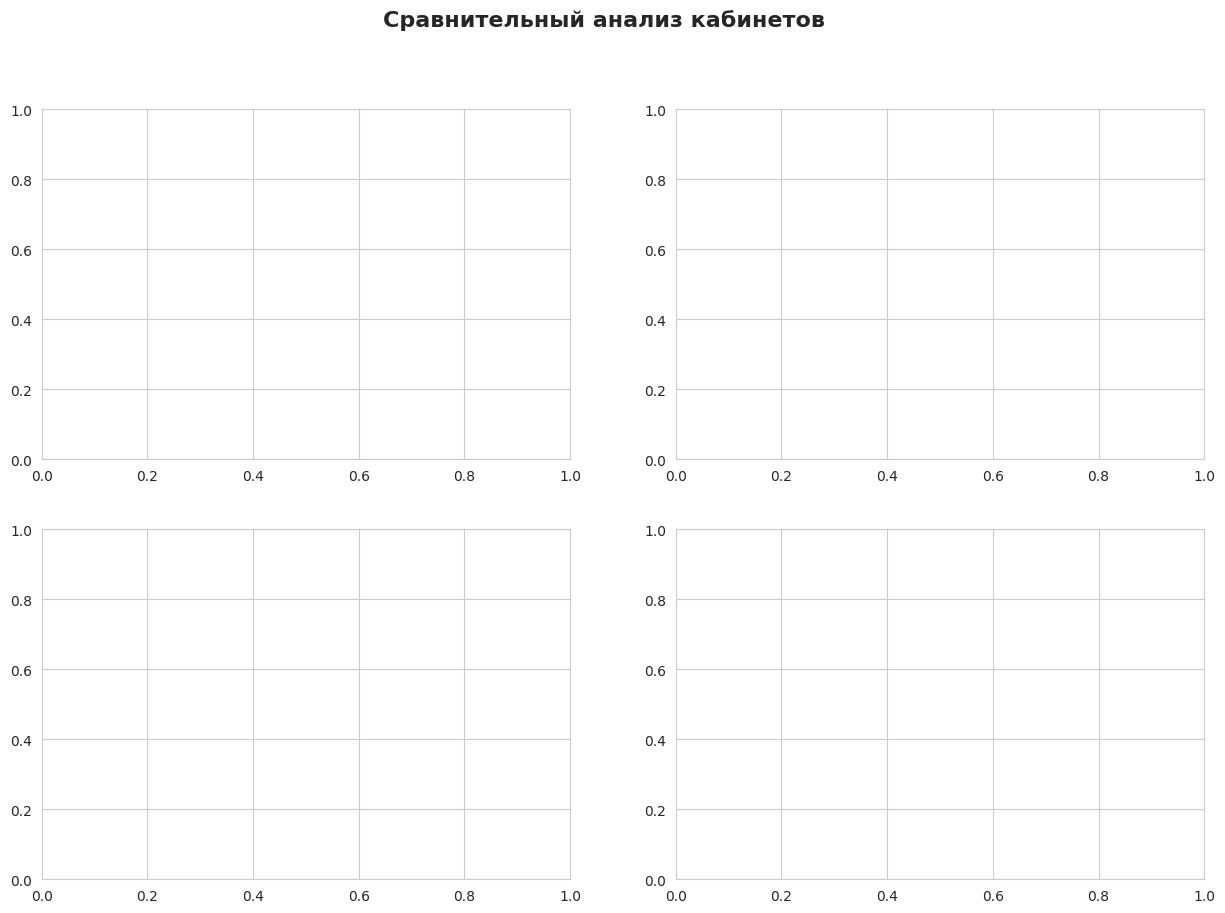

In [18]:
# Сравнение средних значений
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Сравнительный анализ кабинетов', fontsize=16, fontweight='bold')

df_labeled.boxplot(column='temperature_smooth', by='Кабинет', ax=axes[0, 0])
axes[0, 0].set_title('Температура')
axes[0, 0].set_ylabel('°C')
axes[0, 0].set_xlabel('Кабинет')

df_labeled.boxplot(column='humidity_smooth', by='Кабинет', ax=axes[0, 1])
axes[0, 1].set_title('Влажность')
axes[0, 1].set_ylabel('%')
axes[0, 1].set_xlabel('Кабинет')

df_labeled.boxplot(column='co2_smooth', by='Кабинет', ax=axes[1, 0])
axes[1, 0].set_title('CO2')
axes[1, 0].set_ylabel('ppm')
axes[1, 0].set_xlabel('Кабинет')
axes[1, 0].axhline(y=800, color='green', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=1200, color='red', linestyle='--', alpha=0.5)

df_labeled.boxplot(column='CO2 на человека', by='Кабинет', ax=axes[1, 1])
axes[1, 1].set_title('CO2 на человека')
axes[1, 1].set_ylabel('ppm/чел')
axes[1, 1].set_xlabel('Кабинет')

plt.tight_layout()
plt.show()

### 5.5. Корреляционный анализ

/tmp/ipykernel_12145/1654754148.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_labeled[corr_cols].corr()
/home/showbegin/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/showbegin/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


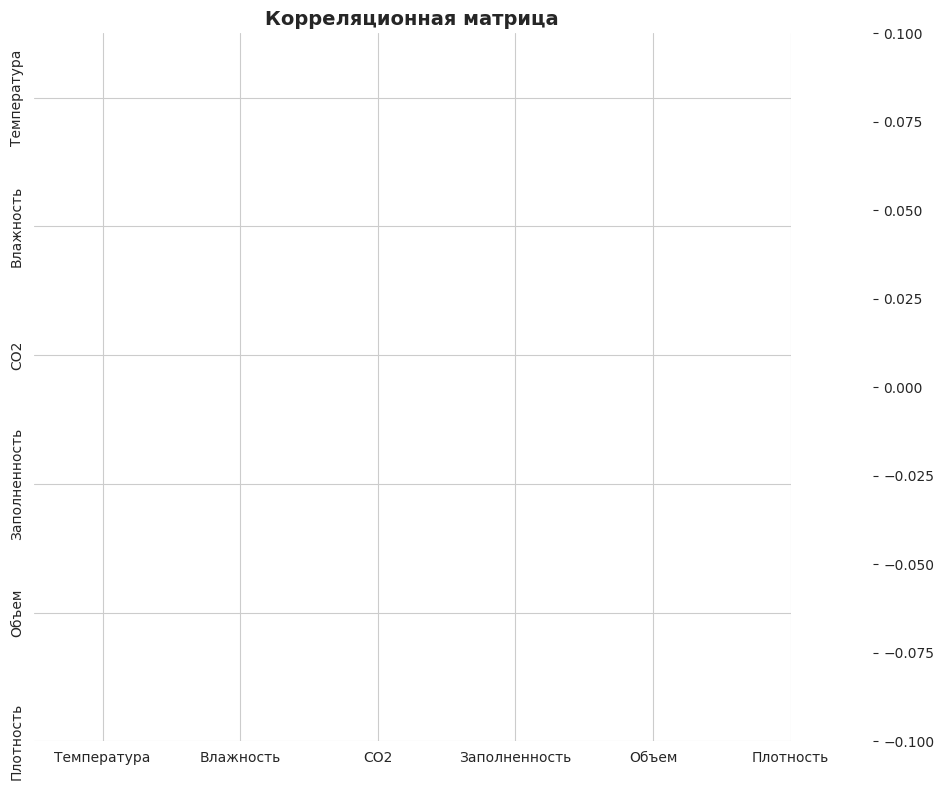

In [ ]:
# Корреляция между параметрами
corr_cols = ['temperature_smooth', 'humidity_smooth', 'co2_smooth',
             'Заполненность (чел)', 'Объем (куб)', 'Плотность (чел/м³)']
corr_matrix = df_labeled[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=['Температура', 'Влажность', 'CO2', 'Заполненность', 'Объем', 'Плотность'],
            yticklabels=['Температура', 'Влажность', 'CO2', 'Заполненность', 'Объем', 'Плотность'])
plt.title('Корреляционная матрица', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Экспорт данных

### 6.1. Подготовка финального датасета

In [20]:
# Выбор колонок для экспорта
export_cols = [
    'datetime',
    'temperature_smooth',
    'humidity_smooth',
    'co2_smooth',
    'Кабинет',
    'Примечание',
    'Объем (куб)',
    'Заполненность (чел)',
    'Плотность (чел/м³)',
    'CO2 на человека'
]

df_export = df_labeled[export_cols].copy()
df_export.columns = [
    'Время',
    'Температура (°C)',
    'Влажность (%)',
    'CO2 (ppm)',
    'Кабинет',
    'Примечание',
    'Объем (м³)',
    'Заполненность (чел)',
    'Плотность (чел/м³)',
    'CO2 на человека (ppm/чел)'
]

print(f"Подготовлено {len(df_export)} записей для экспорта")
df_export.head()

Подготовлено 0 записей для экспорта


,Время,Температура (°C),Влажность (%),CO2 (ppm),Кабинет,Примечание,Объем (м³),Заполненность (чел),Плотность (чел/м³),CO2 на человека (ppm/чел)


### 6.2. Экспорт в CSV

In [21]:
csv_filename = 'co2_analysis_results.csv'
df_export.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"Данные экспортированы в {csv_filename}")

Данные экспортированы в co2_analysis_results.csv


### 6.3. Экспорт в Excel

In [ ]:
excel_filename = 'co2_analysis_results.xlsx'

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='Все данные', index=False)

    summary = df_labeled.groupby('Кабинет').agg({
        'temperature_smooth': ['mean', 'min', 'max'],
        'humidity_smooth': ['mean', 'min', 'max'],
        'co2_smooth': ['mean', 'min', 'max'],
        'Примечание': 'first',
        'Объем (куб)': 'first',
        'Заполненность (чел)': 'first',
        'Плотность (чел/м³)': 'first'
    }).round(2)
    summary.to_excel(writer, sheet_name='Статистика')

    for cabinet in df_labeled['Кабинет'].unique():
        cabinet_data = df_export[df_export['Кабинет'] == cabinet]
        sheet_name = f'Кабинет {cabinet}'
        cabinet_data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Данные экспортированы в {excel_filename}")
print(f"\nСоздано листов:")
print(f"  - Все данные: {len(df_export)} записей")
print(f"  - Статистика: сводка по {len(df_labeled['Кабинет'].unique())} кабинетам")
for cabinet in df_labeled['Кабинет'].unique():
    count = len(df_export[df_export['Кабинет'] == cabinet])
    print(f"  - Кабинет {cabinet}: {count} записей")

Данные экспортированы в co2_analysis_results.xlsx

Создано листов:
  - Все данные: 0 записей
  - Статистика: сводка по 0 кабинетам


## Заключение

Анализ завершен. Результаты сохранены в файлы:
- `co2_analysis_results.csv` - все данные в формате CSV
- `co2_analysis_results.xlsx` - данные и статистика в формате Excel

Основные выводы можно сделать на основе визуализаций и статистики выше.